# Fitting the Low-Rank plus Sparse estimator in R

*Note*: These functions and more will soon be available as part of an R package on CRAN.
In the meantime, this tutorial shows how to: 1) fit the estimator for a given value of the tuning parameters, 2) fit a whole path, 3) perform cross-validation, 4) use a robust estimator of the correlation matrix based on Kendall correlations.

Questions or remarks? : benjamin dot frot @ gmail dot com

## Required packages

The following packages (all available on CRAN) are required to run the code (fit the estimator etc...)

In [101]:
packages <- c("Matrix", "MASS", "mvtnorm", "RSpectra", "matrixcalc", "pcaPP", "cvTools")
install.packages(packages)
for (pkg in packages)
    eval(paste("library(", pkg, ")"))


The downloaded binary packages are in
	/var/folders/d7/dhbt8tyd3ksf__y96t051n100000gn/T//RtmpM5NVQY/downloaded_packages


The following additional packages are used in this notebook:

In [8]:
packages <- c("ggplot2")
install.packages(packages)
library(ggplot2)
library(reshape2)

library(repr)
options(repr.plot.width=4, repr.plot.height=4)


The downloaded binary packages are in
	/var/folders/d7/dhbt8tyd3ksf__y96t051n100000gn/T//RtmpM5NVQY/downloaded_packages


## Fitting the estimator for a given value of the tuning parameters

Recall that given an $n \times p$ data matrix $X$ constiting of $n$ realisations of a random vector $x \in \mathbb{R}^p \sim \mathcal{N}(0, \Sigma)$, the so-called "Low-rank plus Sparse" (LRpS) estimator defined in https://projecteuclid.org/euclid.aos/1351602527 optimises the following function:
$$
  (\hat{S} , \hat{L}) = \arg \min_{S - L \succ 0, L \succeq 0} - \log\det (S - L) + 
  Tr((S - L)\hat{\Sigma}) + \lambda (\gamma ||S||_1 + (1 - \gamma)Tr(L) ),
$$
where $\hat{\Sigma}$ is some estimator of $\Sigma$ (typically the sample covariance matrix), $\lambda > 0$ and $\gamma \in (0, 1)$ are tuning parameters.

### Generate some data

Let us start by generating some synthetic data we can fit the estimator to.

In [90]:
p <- 100 # Number of obvserved variables 
h <- 3 # Number of hidden variables
n <- 2000 # Number of samples
set.seed(0)
source("./utils//simulate_data.R")
toy.data <- simulate.latent.ggm.data(n = n, p = p, h = h, outlier.fraction = 0.0) # Data from a multivariate normal
X <- toy.data$obs.data # The observed data
X <- scale(X)
# The true sparse matrix we try to estimate
true.S <- toy.data$true.precision.matrix[1:p,1:p]
# Let us keep only the non-diagonal entries
true.S <- 1 * ((true.S - diag(diag(true.S))) != 0)

Let us see what the sparse matrix we try to estimate looks like

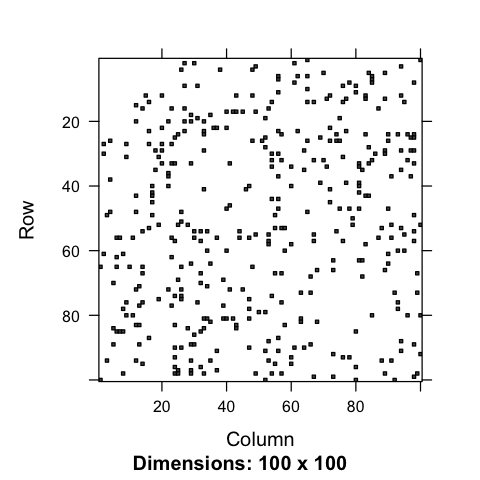

In [91]:
image(Matrix(true.S, sparse = T))

### Fit the estimator

[1] "Term Msg: Convergence reached."
[1] "Number of iterations: 35"
[1] "Precision: 1 Recall: 0.0829015544041451"
[1] "Rank of L: 6"


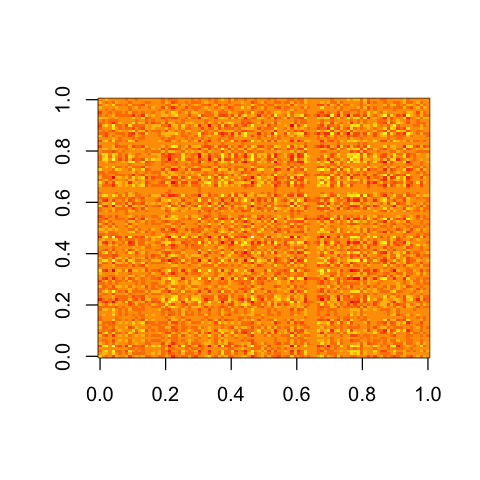

In [99]:
source("./lrps/fast_lrps_admm.R")
Sigma <- cor(X) # The sample correlation matrix

# Some reasonable values of the tuning parameters
lambda <- 0.45
gamma <- 0.2
lam1 <- lambda * gamma
lam2 <- lambda * (1 - gamma)

fit <- fit.low.rank.plus.sparse(Sigma = Sigma, Lambda1 = lam1, Lambda2 = lam2, n = nrow(X), 
                                tol = 1e-07, print_progress = F)
print(paste("Term Msg:", fit$termmsg))
print(paste("Number of iterations:", fit$iter))

# Let us get the parameters we fitted
S <- fit$S # The estimated Shat
Sbin <- 1 * ((fit$S - diag(diag(fit$S))) !=0)
L <- fit$L

# Let us see what the precision and recall are for the recovery of S
recall <- sum(Sbin * true.S) / sum(true.S)
precision <- sum(Sbin * true.S) / sum(Sbin)
print(paste("Precision:", precision, "Recall:", recall))
print(paste("Rank of L:", sum(eigen(L)$val > 1e-6)))

# Let us look at the low-rank matrix L
image(L)

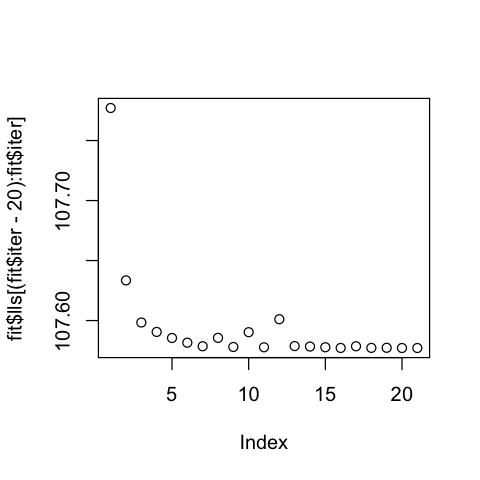

In [104]:
# What did the log-likelihood look like during the last 20 the iterations?
plot(fit$lls[(fit$iter-20):fit$iter])

Note that it does not decrease monotically for two reasons: the algorithm is accelerated, so we get Nesterov-like "ripples" and we use restarts. This is the algorithm with restarts described here: ftp://ftp.math.ucla.edu/pub/camreport/cam12-35.pdf